In [13]:
import numpy as np
import matplotlib.pyplot as plt
from common.layers import MatMul
from common.util import preprocess

In [4]:
c = np.array([[1, 0, 0, 0, 0, 0, 0]])

W = np.random.randn(7,3)

layer = MatMul(W)
h = layer.forward(c)

print(h)

[[-0.62476904 -1.14783479 -0.6359609 ]]


# シンプリなword2vec  
<br>  
・word2vecのニューラルネットワークのモデルはCBOW(continuous bag-of-words)とskip-gramの２つがある  
<br>
・今回はCBOWを使用  

In [7]:
# 模擬的なCBOW

# 入力層1, 2のコンテキストデータ(one-hot)
c0 = np.array([[1, 0, 0, 0, 0, 0, 0]])
c1 = np.array([[0, 1, 0, 0, 0, 0, 0]])

# weight
W_in = np.random.randn(7, 3)
W_out = np.random.randn(3, 7)

# layers
in_layer0 = MatMul(W_in)
in_layer1 = MatMul(W_in)
out_layer = MatMul(W_out)

# forward
h0 = in_layer0.forward(c0)
h1 = in_layer1.forward(c1)
h = 0.5 * (h0 + h1)
s = out_layer.forward(h)

print(s)


[[-0.97290336  1.09830483  1.0189462   0.50007027 -1.11189093 -1.37018336
  -0.80683766]]


In [18]:
# コンテキストとターゲットの作成関数 -> returnは単語id
def create_contexts_target(corpus, window_size=1):
    target = corpus[window_size:-window_size] # 末端を除く
    context = []

    for idx in range(window_size, len(corpus)-window_size):
        cs = [] # 一時的なコンテキストの格納
        for t in range(-window_size, window_size+1):
            if t == 0:
                continue
            cs.append(corpus[idx + t])
        context.append(cs)

    return np.array(context), np.array(target)

In [21]:
text = 'You say goodbye and I say hello.'
corpus, id_to_word, word_to_id = preprocess(text)

context, target = create_contexts_target(corpus)
print(context)
print(target)

# 単語idなのでone-hotに変換する

[[0 2]
 [1 3]
 [2 4]
 [3 1]
 [4 5]
 [1 6]]
[1 2 3 4 1 5]


## One-hot表現の変換

In [23]:
from common.util import convert_one_hot

text = 'You say goodbye and I say hello.'
corpus, id_to_word, word_to_id = preprocess(text)

context, target = create_contexts_target(corpus)

# one-hot
vocab_size = len(word_to_id)
target = convert_one_hot(target, vocab_size)
contexts = convert_one_hot(context, vocab_size)


In [74]:
# simple CBOWの実装

from common.layers import MatMul, SoftmaxWithLoss


class SimpleCBOW:
    def __init__(self, vacab_size, hidden_size):
        V, H = vocab_size, hidden_size

        # weight
        W_in = 0.01 * np.random.randn(V, H).astype('f')
        W_out = 0.01 * np.random.randn(H, V).astype('f')
        self.W_in = W_in

        # layers
        self.in_layer0 = MatMul(W_in) 
        self.in_layer1 = MatMul(W_in) # layer0と同じ重み
        self.out_layer = MatMul(W_out)
        self.loss_layer = SoftmaxWithLoss()

        # 勾配とweightをまとめる
        layers = [self.in_layer0, self.in_layer1, self.out_layer]
        self.params, self.grads = [], []
        for layer in layers:
            self.params += layer.params
            self.grads += layer.grads

        self.word_vecs = W_in


    def forward(self, contexts, target):
        h0 = self.in_layer0.forward(contexts[:, 0])
        h1 = self.in_layer1.forward(contexts[:, 1])
        h = (h0 + h1)*0.5
        score = self.out_layer.forward(h)
        loss = self.loss_layer.forward(score, target)
        return loss


    def backward(self, dout=1):
        ds = self.loss_layer.backward(dout)
        da = self.out_layer.backward(ds)
        da *= 0.5
        self.in_layer1.backward(da)
        self.in_layer0.backward(da)
        return None
    

## 学習コードの実装

| epoch 1 |  iter 1 / 2 | time 0[s] | loss 1.95
| epoch 2 |  iter 1 / 2 | time 0[s] | loss 1.95
| epoch 3 |  iter 1 / 2 | time 0[s] | loss 1.95
| epoch 4 |  iter 1 / 2 | time 0[s] | loss 1.95
| epoch 5 |  iter 1 / 2 | time 0[s] | loss 1.95
| epoch 6 |  iter 1 / 2 | time 0[s] | loss 1.95
| epoch 7 |  iter 1 / 2 | time 0[s] | loss 1.95
| epoch 8 |  iter 1 / 2 | time 0[s] | loss 1.95
| epoch 9 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 10 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 11 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 12 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 13 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 14 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 15 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 16 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 17 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 18 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 19 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 20 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 21 |  iter 1 / 2 | ti

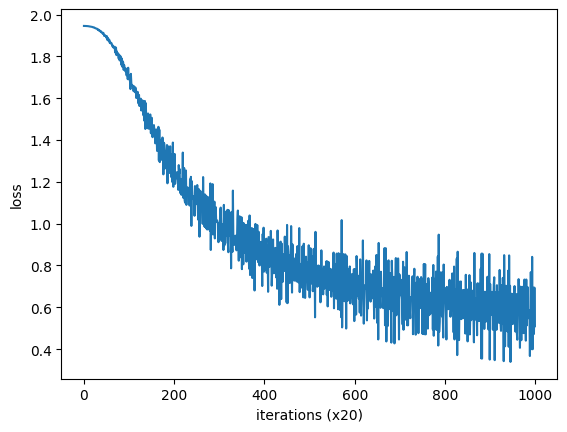

In [75]:
from common.trainer import Trainer
from common.optimizer import Adam
from common.util import preprocess, create_contexts_target, convert_one_hot



window_size = 1
hidden_size = 5
batch_size = 3
max_epoch = 1000


text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)
vacab_size = len(word_to_id)

contexts, target = create_contexts_target(corpus, window_size)
target = convert_one_hot(target, vocab_size)
contexts = convert_one_hot(contexts, vocab_size)


model = SimpleCBOW(vacab_size, hidden_size)
optimizer = Adam()
trainer = Trainer(model, optimizer)

trainer.fit(contexts, target, max_epoch, batch_size)
trainer.plot()

In [76]:
model.word_vecs

array([[-1.2174246 , -1.1714272 , -1.2371223 ,  1.2026607 ,  1.0656954 ],
       [ 0.23632112,  1.1730875 ,  1.1869189 , -1.1746894 , -1.1704252 ],
       [-0.81316656, -0.73586535, -0.6650108 ,  0.6605    ,  0.8488654 ],
       [ 1.9140412 ,  0.9914481 ,  1.046924  , -0.97958547, -0.9081628 ],
       [-0.817871  , -0.7441267 , -0.6782237 ,  0.6905391 ,  0.8573698 ],
       [-1.2223462 , -1.1514242 , -1.2578977 ,  1.1890907 ,  1.0615234 ],
       [-1.7637032 ,  1.0806384 ,  1.0041534 , -1.090262  , -1.112264  ]],
      dtype=float32)

In [77]:
model.W_in

array([[-1.2174246 , -1.1714272 , -1.2371223 ,  1.2026607 ,  1.0656954 ],
       [ 0.23632112,  1.1730875 ,  1.1869189 , -1.1746894 , -1.1704252 ],
       [-0.81316656, -0.73586535, -0.6650108 ,  0.6605    ,  0.8488654 ],
       [ 1.9140412 ,  0.9914481 ,  1.046924  , -0.97958547, -0.9081628 ],
       [-0.817871  , -0.7441267 , -0.6782237 ,  0.6905391 ,  0.8573698 ],
       [-1.2223462 , -1.1514242 , -1.2578977 ,  1.1890907 ,  1.0615234 ],
       [-1.7637032 ,  1.0806384 ,  1.0041534 , -1.090262  , -1.112264  ]],
      dtype=float32)

In [59]:
context[:, 0]

array([0, 1, 2, 3, 4, 1])